# A* algorithm (with cons/incons heuristic)

![1](./image/1.png)

In this lab we consider the problem of finding a (shortest) path on a graph of special structure, widely used in robotics and computer games, i.e. a grid. Grid is composed of the free and blocked cells and an agent may move from one free cell to the other. The connectivity of the grid may vary, e.g. grid might be 4-connected when only cardinal moves are allowed, 8-connected when diagonal moves are allowed as well, etc. 

**In this lab we assume that the grid is 4-connected**, i.e. only moves into the cardinal direction (N,E,W,S) are allowed. The cost of each move is uniform, i.e. 1.

We will consider the semminal `A*` algorithm for finding the shortest path on a grid.

We will use two heuristic functions: Manhattan (admissible, consistent) and ''noisy Manhattan'' (admissible, inconsistent) and code two implementations of `A*`: with and without re-opening the nodes. We will evidently see that the latter might not correctly solve the problem with the inconsistent heuristic.

It is supposed that our implementation of `A*` will be largely based on the implementation of the `Dijkstra`'s algrotihm that we did in the previous lab. 

Your task is to complete and run every cell in this notebook.

Let's go for it!

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
%matplotlib inline

### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [2]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]


    def get_neighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 4-connected (i.e. only moves into cardinal directions are allowed)
        '''   
        neighbors = []
#         delta = [[0, 1], [1, 0], [0, -1], [-1, 0], [1,1],[1,-1],[-1,-1],[-1,1]]
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return (self._height, self._width)


Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In case of 4-connected grid it is always equal to 1. However if the connectivity of a grid exceeds 4 the cost of a transition may vary.

Recall that in this lab we assume 4-connected grid, i.e. only cardinal moves are allowed.

In [3]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves between cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) == 1: #cardinal move
        return 1
    else:
        raise Exception('Trying to compute the cost of non-supported move! ONLY cardinal moves are supported.')
#     return np.sqrt((i1-i2)**2 + (j1-j2)**2)


### Search Node

Search node is the core concept for any (heuristic) search algorithm. It ties together and encapsulates data both about the state of the problem at hand (in the considered case state = the position of the robot/agent on a grid) and data needed to conduct the search (g-, h, f-values etc.)


In [4]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node // always 0 for Dijkstra
    - F: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node 

    '''
    

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None, tie_breaking_func = None):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent
        
    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        return (self.i == other.i) and (self.j == other.j)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        ij = self.i, self.j
        return hash(ij)


    def __lt__(self, other): 
        '''
        Comparing the keys (i.e. the f-values) of two nodes,
        which is needed to sort/extract the best element from OPEN.
        
        This comparator is very basic. We will code a more plausible comparator further on.
        '''
        return  self.f < other.f

### Visualization

In [5]:
def draw(grid_map, start = None, goal = None, path = None, nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 5
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodes_opened is not None:
        for node in nodes_opened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)
    
    if nodes_expanded is not None:
        for node in nodes_expanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)
    
    if nodes_reexpanded is not None:
        for node in nodes_reexpanded:
                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(255, 145, 146), width=0)
    
    if path is not None:
        for step in path:
            if (step is not None):
                if (grid_map.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()


Example of the visualization

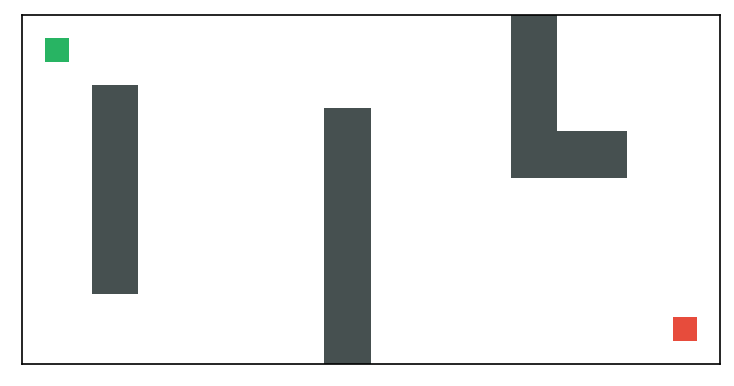

In [6]:
height = 15
width = 30
map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

### Implementing the search tree (i.e. OPEN and CLOSED)

Efficient implementation of the search tree (OPEN and CLOSED) is crucial for any search algorithm. You should use your efficient implementation of the search tree that you've created in the previous lab (`Dijkstra`'s algorithm).

In [7]:
class SearchTreePQS: #Non list-based implementation of the search tree
    
    def __init__(self):
        self._open = []           # heap for the OPEN nodes
        self._closed = set()       # set for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    '''    
    def add_to_open(self, item):
        heappush(self._open, item)   
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    
    def was_expanded(self, item):
        return item in self._closed
    
    def get_best_node_from_open(self):
        best_node = heappop(self._open)
        
        while self.was_expanded(best_node) and not self.open_is_empty():
            best_node = heappop(self._open)
        
        return best_node

    def add_to_closed(self, item):
        self._closed.add(item)

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

### Validating the results


In [8]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length


`simple_test` tests the pathfing algorithm on a single simple instance. Tests assume that the search function fits the following pattern:


`search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, nodes_created, discovered, expanded)`, where

- `task_map` -- grid
- `start.i, start.j` -- (i,j) coordinates of the start cell
- `goal.i, goal.j` -- (i,j) coordinates of the goal cell
- `*optional arguments*` -- additional parameters of the search function, passed with `*args`. E.g. the heuristic function.
- `path_found` -- `True` if path was found, `False` otherwise
- `last_state` -- last state of the path. `None` if path was not found
- `steps` -- the number of search steps
- `nodes_created` -- the number of the nodes, which were created and stored during the search process 
- `open` -- iterable collection of open nodes
- `expanded` --  iterable collection of the expanded nodes
- `re-expanded` -- iterable collection of the re-expanded nodes

In [9]:
def simple_test(search_func, task, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    lengths = [36, 30, 30, 21, 28, 24, 32, 27, 42, 23, 35, 37, 23, 26, 40, 36, 42, 28, 44, 36, 38, 29, 33, 42, 44]

    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args)
        number_of_steps = result[2]
        nodes_created = result[3]
        if result[0]:
            path = make_path(result[1])
            correct = int(path[1])  == int(length)
            print("Path found! Length: " + str(path[1]) + \
                ". Nodes created: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps) + ". Correct: " + str(correct))
            draw(task_map, start, goal, path[0], *result[4:])
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


In [10]:
def read_task_from_file(path):
    '''
    Reads map, start/goal positions and true value of path length between given start and goal from file by path. 
    '''

    tasks_file = open(path)
    height = int(tasks_file.readline())
    width = int(tasks_file.readline())
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in tasks_file:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == '#':
                cells[i][j] = 1
            else:
                continue
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break
    
    start_i = int(tasks_file.readline())
    start_j = int(tasks_file.readline())
    goal_i = int(tasks_file.readline())
    goal_j = int(tasks_file.readline())
    length = float(tasks_file.readline())
    return (width, height, cells, start_i, start_j, goal_i, goal_j, length)


In [11]:
def massive_test(search_func, data_path, num_of_tasks=None, *args):
    '''
    massive_test runs search_func on set of differnt tasks (from directory data/) 
    with *args as optional arguments and 
    for every task displays the short report:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task.
    
    the function also returns a dictionary with statistics. 
    It contains the next fields:
     - "corr" -- the correctness of every path length (True/False)
     - "len" -- the length of every path (0.0 if path not found)
     - "nc" -- the number of created nodes for every task execution
     - "st" -- the number of steps of algorithm for every task execution
    '''
    
    stat = dict()
    stat["corr"] = []
    stat["len"] = []
    stat["nc"] = []
    stat["st"] = []
    
    if (num_of_tasks is None) or (num_of_tasks<=0):
        print("Incorrect number of tasks. Testing halted!")
        return stat
    
    task_num = num_of_tasks
    task_map = Map()
    for task_count in range(task_num):
        task_file_name = data_path + str(task_count) + ".map"
        width, height, cells, start_i, start_j, goal_i, goal_j, length = read_task_from_file(task_file_name)
        task_map.set_grid_cells(width, height, cells)
        try:
            result = search_func(task_map, start_i, start_j, goal_i, goal_j, *args)
            number_of_steps = result[2]
            nodes_created = result[3]
            if result[0]:
                path = make_path(result[1]) 
                stat["len"].append(path[1])
                draw(task_map, start, goal, path[0], *result[4:])
                correct = int(path[1])  == int(length)
                stat["corr"].append(correct)

                print("Path found! Length: " + str(path[1]) +\
                    ". Nodes created: " + str(nodes_created) + \
                    ". Number of steps: " + str(number_of_steps) + \
                    ". Correct: " + str(correct))
            else:
                print("Path not found!")
                stat["corr"].append(False)
                stat["len"].append(0.0)

            stat["nc"].append(nodes_created)
            stat["st"].append(number_of_steps)

        except Exception as e:
            print("Execution error")
            print(e)

    return stat

## A* Algorithm (without re-expansions)

The first (main) ingridient of the `A*` algorithm is the heuristic function.

Ideally, it should be admissible (never overestimate the true cost to the goal) and consistent (~satisfy triangle inequality). 

Manhattan distance is, indeed, admissable and consistent heuristic for 4-connected grids.

Thus, if we plug it in into the `Dijkstra`'s search loop from the previous lab we will end up with `A*`.

Let's go for it.

In [12]:
def manhattan_distance(i1, j1, i2, j2):
    '''
    Returns sum of differences between cordinates
    '''
    return abs(i1 - i2) + abs(j1 - j2)


In [13]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    Modified Dijkstra algorithm for monotonous heuristics
    '''
    ast = search_tree()
    steps = 0
    nodes_created = 0
    
    goal = (goal_i, goal_j)
    start = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, *goal), parent=None)
    ast.add_to_open(start)
    
    while not ast.open_is_empty():
        steps += 1
        best_node = ast.get_best_node_from_open()
        best = (best_node.i, best_node.j)
        ast.add_to_closed(best_node)
        
        
        if (best == goal):
            return True, best_node, steps, nodes_created, ast.OPEN, ast.CLOSED
        
        for succ in grid_map.get_neighbors(*best):
            new_node = Node(*succ, best_node.g + compute_cost(*best, *succ), heuristic_func(*succ, *goal), parent=best_node)
            nodes_created += 1
            if not ast.was_expanded(new_node):
                ast.add_to_open(new_node)
    return False, None, steps, nodes_created, ast.OPEN, ast.CLOSED


Path found! Length: 30. Nodes created: 490. Number of steps: 134. Correct: True


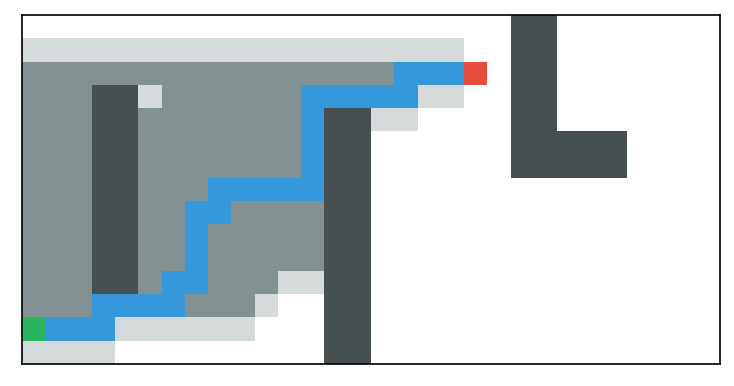

CPU times: total: 78.1 ms
Wall time: 66 ms


In [14]:
'''
This should work correct in case your implementation of A* is correct.
Play with the number of test instance (2nd argument) to run
the search algorithm on different start/goal pairs.
'''
%time res = simple_test(astar, 1, manhattan_distance, SearchTreePQS)

In [15]:
def euclidian_distance(i1, j1, i2, j2):
    '''
    Returns sum of differences between cordinates
    '''
    return np.sqrt((i1 - i2)**2 + (j1 - j2)**2)


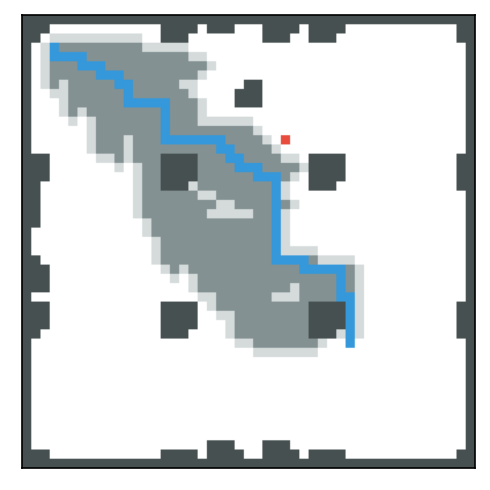

Path found! Length: 64. Nodes created: 1734. Number of steps: 441. Correct: True


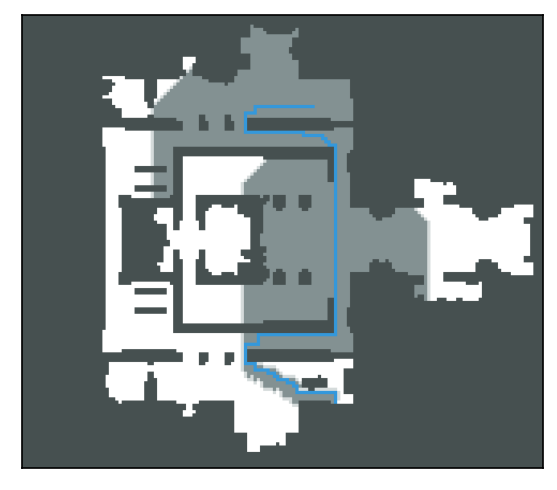

Path found! Length: 197. Nodes created: 13348. Number of steps: 3532. Correct: True


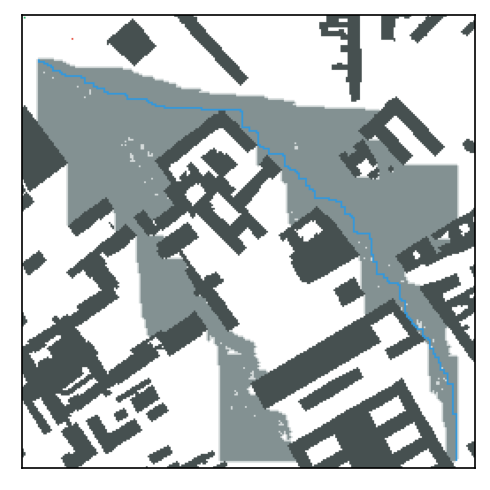

Path found! Length: 462. Nodes created: 68358. Number of steps: 17344. Correct: True


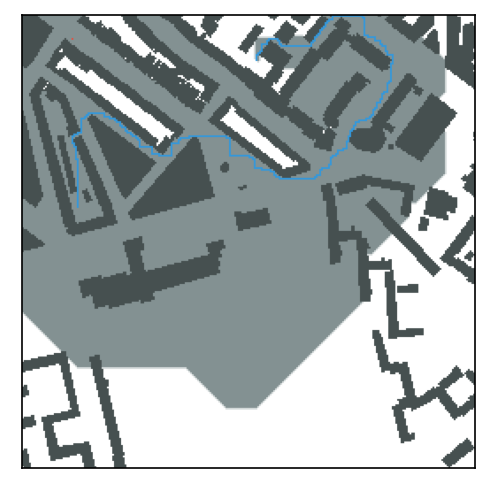

Path found! Length: 498. Nodes created: 105357. Number of steps: 27371. Correct: True


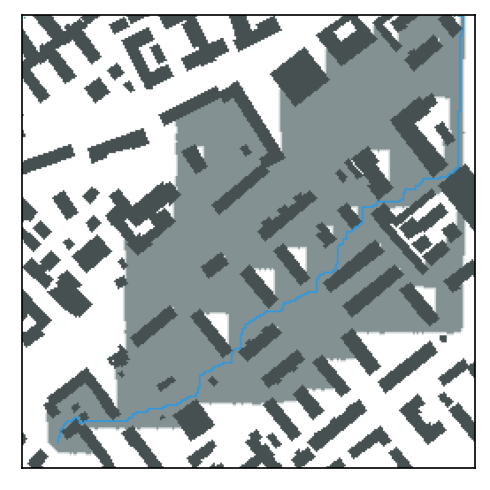

Path found! Length: 479. Nodes created: 91976. Number of steps: 23723. Correct: True


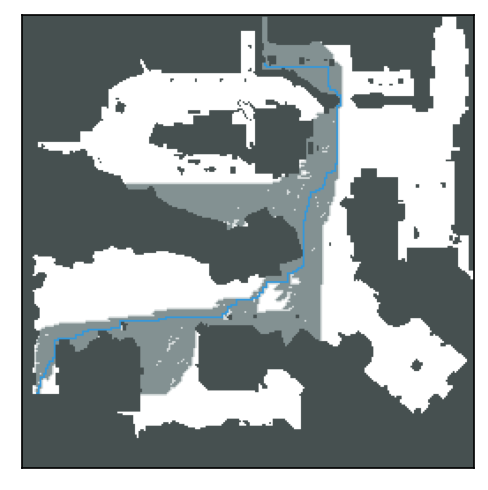

Path found! Length: 402. Nodes created: 28502. Number of steps: 7323. Correct: True


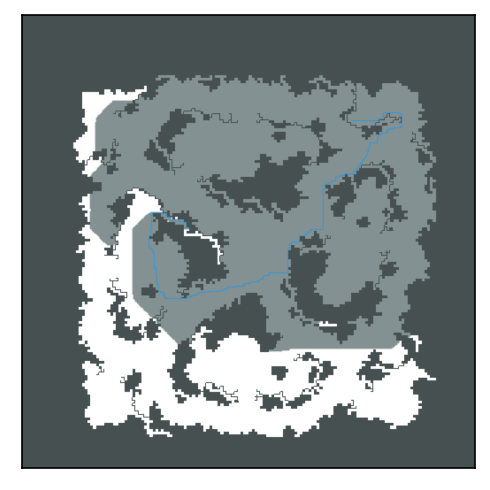

Path found! Length: 721. Nodes created: 291884. Number of steps: 75033. Correct: True


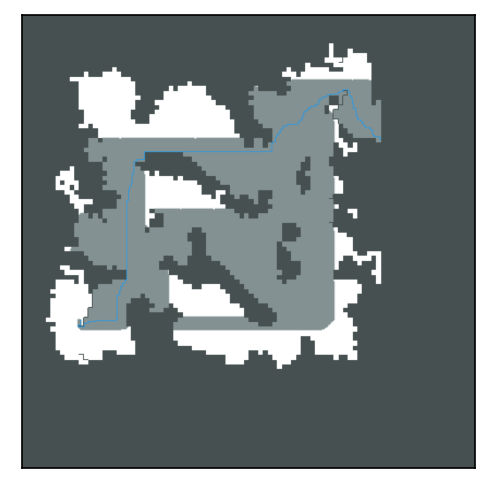

Path found! Length: 678. Nodes created: 196444. Number of steps: 49768. Correct: True


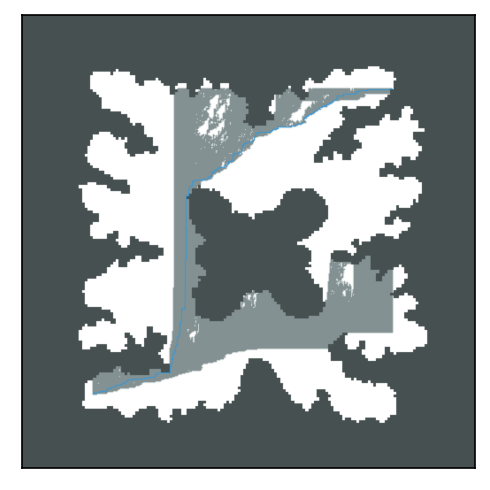

Path found! Length: 683. Nodes created: 113877. Number of steps: 28727. Correct: True
CPU times: total: 8.98 s
Wall time: 9.14 s


In [16]:
'''
Let's run your (efficient) implementation of A* on the full set of
large instances (9 instances in total). All should be correct.

On my modern laptop (2022 Asus, Intel Core i7, 16Gb RAM, SSD) the whole test completes 
in about 3 seconds (~= 1/2 of Dijkstra's runtime -- see the previous lab).
'''
%time res = a_star_stat = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQS)

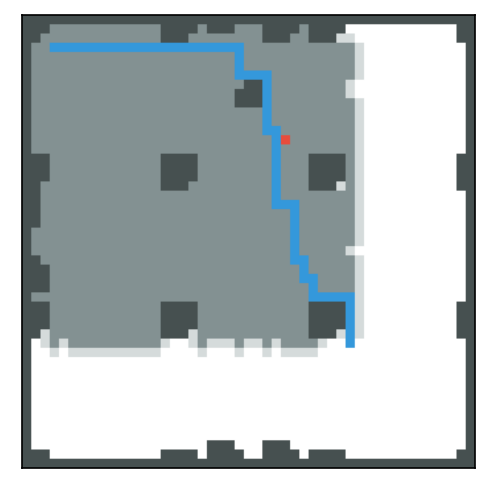

Path found! Length: 64. Nodes created: 4159. Number of steps: 1079. Correct: True


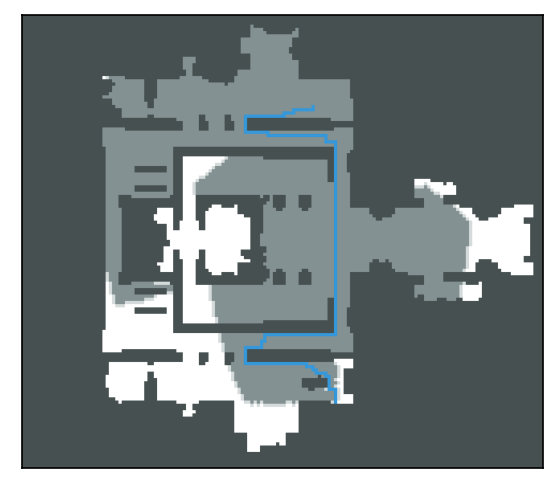

Path found! Length: 197. Nodes created: 19232. Number of steps: 5105. Correct: True


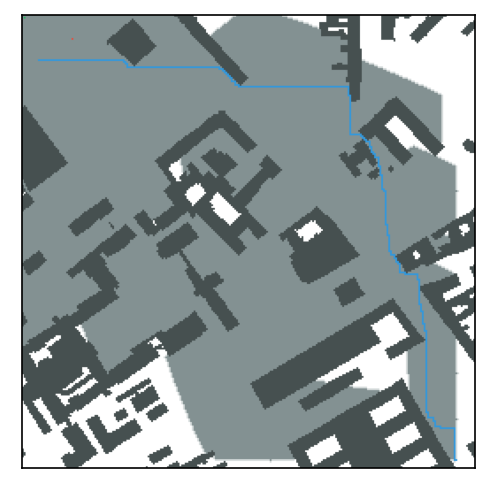

Path found! Length: 462. Nodes created: 147240. Number of steps: 37744. Correct: True


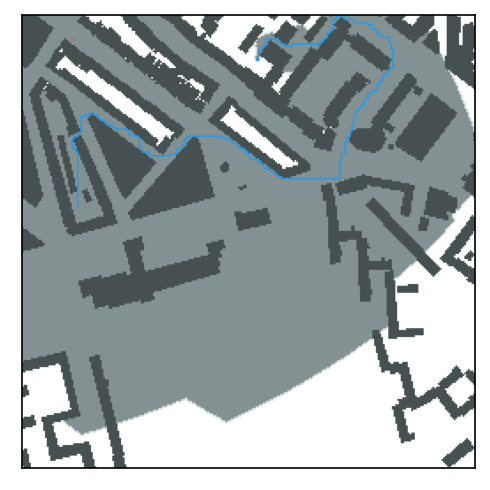

Path found! Length: 498. Nodes created: 125215. Number of steps: 32490. Correct: True


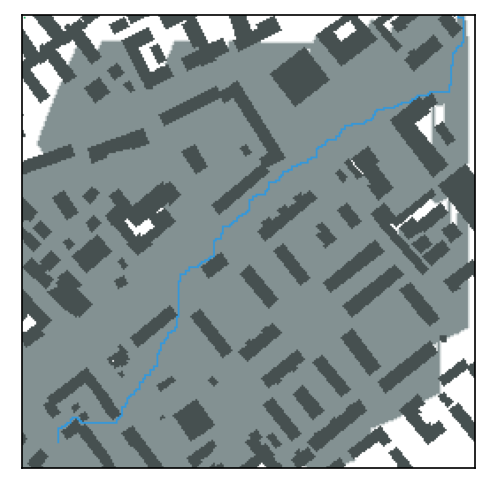

Path found! Length: 479. Nodes created: 162184. Number of steps: 42178. Correct: True


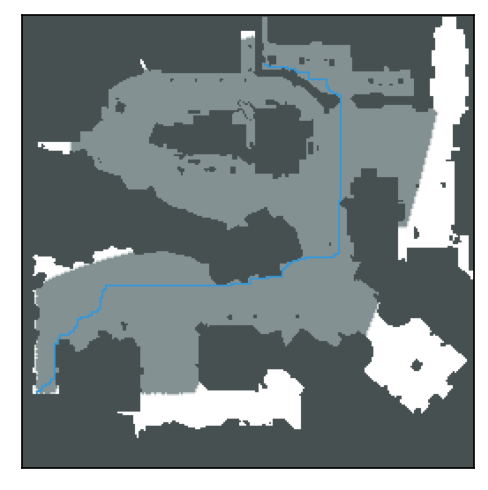

Path found! Length: 402. Nodes created: 82044. Number of steps: 21114. Correct: True


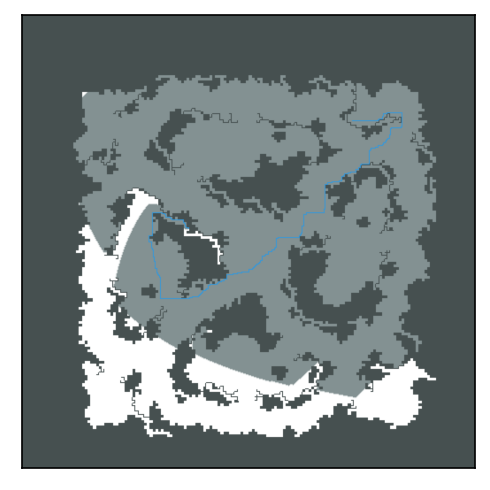

Path found! Length: 721. Nodes created: 337519. Number of steps: 86806. Correct: True


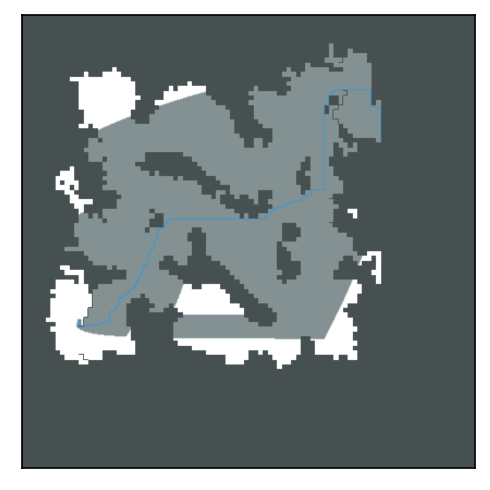

Path found! Length: 678. Nodes created: 250868. Number of steps: 63666. Correct: True


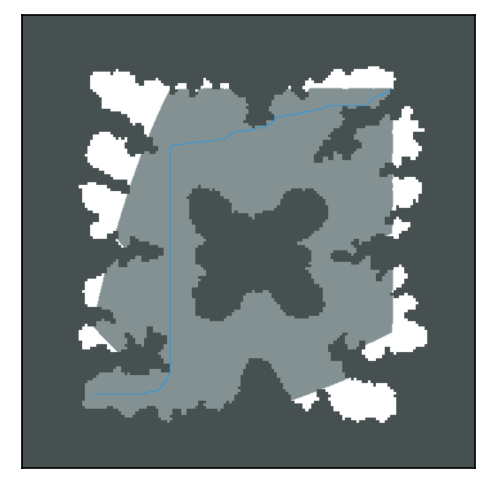

Path found! Length: 683. Nodes created: 300567. Number of steps: 75978. Correct: True
CPU times: total: 14.6 s
Wall time: 14.7 s


In [17]:
%time res = a_star_stat = massive_test(astar, "data/", 9, euclidian_distance, SearchTreePQS)

## Inconsistent Heuristic Function

Admissible but inconsistent heuristic might lead to an incorrect behaviour in case you did not implement re-opening/re-expansion in `A*` (as we did so far). Let's see it with our own eyes.

In [18]:
def inconsistent_heuristic(i1, j1, i2, j2):
    '''
    A basic not consistent heuristic function for simple_test map, that based on manhattan_distance multiplied by coefficient from 0 to 1. 
    Such range of coefficient ensures that the function does not overestimate the true spacing between cells, but makes it inconsistent.
    '''
    coef = [[0.32831655869667997, 0.02602781916714625, 0.32602955554375024, 0.06234916377268629, 0.35295444407424986, 0.4399763742097014, 0.46962919934270825, 0.16144646916333383, 0.04178119522641788, 0.3615984917894237, 0.1663930560924083, 0.1556095515496247, 0.023184930929364966, 0.2417350062696204, 0.14690725879414124, 0.020766506492569392, 0.006869319632844428, 0.3824707325836774, 0.3912138018969597, 0.201089314826286, 0.2884529835910057, 0.4795063591225301, 0.10333745819385776, 0.33834740384881046, 0.08447318037398205, 0.010754818060922267, 0.23611557024543672, 0.3629237250718168, 0.3678390854556626, 0.0006988268075135973], [0.17081730580243898, 0.42815946938275257, 0.024739567784460792, 0.2384247988728579, 0.4480895478056663, 0.43049105235702034, 0.3649923418701008, 0.08565497107344322, 0.4069843090234916, 0.32498662639563125, 0.2826508716412064, 0.1973909468425717, 0.4125632682759354, 0.29608357889521686, 0.04662324665294576, 0.32915442809479756, 0.08864327609387218, 0.4643067499890007, 0.3963962928888365, 0.0402016795594885, 0.2954060455404461, 0.38728059734093084, 0.19527308273361277, 0.3170835313741325, 0.3294472639012368, 0.302480192507245, 0.23827669438631033, 0.11079177021531394, 0.43438329910834717, 0.1465810756285223], [0.27794966579449815, 0.4958689976703051, 0.2367219131177683, 0.11742295670949221, 0.36177711351980735, 0.20951533058916783, 0.3063171220477524, 0.2728786620098217, 0.2959417227081334, 0.4209509633145379, 0.32077674238174947, 0.3532802742140129, 0.10159841447119167, 0.2625386536587789, 0.23272086429640437, 0.4119533662959103, 0.46798257469700083, 0.43826446882497194, 0.19412482734352465, 0.41570757993008334, 0.09194411485967935, 0.3374939455246143, 0.48950601103738256, 0.045810930194507216, 0.4681125020725993, 0.44697056880494346, 0.2974354458736584, 0.09661345183840903, 0.10179352117821233, 0.4984785204236554], [0.31651770176123994, 0.1993533617539145, 0.05498519883408326, 0.407507877609872, 0.20989800681581555, 0.23189729215295218, 0.47632912929283583, 0.44082813541052335, 0.37641111507987496, 0.3705325659565917, 0.27114709146390303, 0.2749722526417302, 0.17510400455600839, 0.24928453580259324, 0.26706843358187277, 0.20003119594515434, 0.48517351349738025, 0.358737443887516, 0.014499586935358744, 0.3695458096843226, 0.4139350643060239, 0.2637524793563651, 0.4333072493320588, 0.3866231497861453, 0.11568118966984908, 0.3866545361237745, 0.37255358968718705, 0.4536093231053632, 0.028298598616680992, 0.3843631281995794], [0.022936654540356094, 0.25692869680419306, 0.19114439827311597, 0.003914578307714578, 0.39772983606753926, 0.48127846041963485, 0.15484631395861503, 0.17908081898759592, 0.3090343519006113, 0.10462195950165115, 0.25317932866238774, 0.2009237282348788, 0.09359760036914322, 0.40364807856529455, 0.055891331785010545, 0.16337863324659613, 0.2691732384510364, 0.07486676107970769, 0.2314626630913364, 0.12306319045683534, 0.11356274675838057, 0.4599953194126375, 0.47460828131193905, 0.005834864826164188, 0.23612309430392764, 0.24485991819861713, 0.3434512516138732, 0.0016997052470916763, 0.4652005711931813, 0.10897558145101721], [0.4177181343966487, 0.09069818058411377, 0.2583378454221766, 0.2926980136879932, 0.26099645390826415, 0.18663359178918487, 0.16494752746012747, 0.3045066233089356, 0.030327171547539444, 0.24211821728616623, 0.21020550645343966, 0.3254991411698671, 0.04408967134538244, 0.18516527405991012, 0.226869664228824, 0.35029312220233516, 0.48700545978262755, 0.03419912948567566, 0.024283669463694313, 0.47335552232710487, 0.42404061979262847, 0.33043653199901163, 0.2035393825503235, 0.14279930595010976, 0.41988656885759507, 0.41249205988560517, 0.2862977326301444, 0.09366895332179775, 0.45524177915388536, 0.3173102222994394], [0.3479789803766766, 0.12562823926040556, 0.0721693670613146, 0.20546695912853757, 0.307432280661857, 0.15892258220830824, 0.3307928002878911, 0.4282389396286852, 0.31895994328404403, 0.015396070429757436, 0.41000311890122926, 0.21378824993375084, 0.008321262258760398, 0.4013416238710389, 0.11679565203646447, 0.39068214734907575, 0.02756563930087408, 0.0864279961796352, 0.06269745872485477, 0.44744087209088734, 0.08554027053671065, 0.25808842487838324, 0.3792373276058973, 0.26592827742194886, 0.13573466401440826, 0.4221104642788447, 0.06931890321196982, 0.4811769460605059, 0.07160913132384294, 0.2209815674928729], [0.047394725493421, 0.3254532739454676, 0.4889474568782018, 0.4884912459734134, 0.08899137271945917, 0.0775187529515095, 0.036745730507082686, 0.46210733564619816, 0.46448504074512464, 0.27123073573140677, 0.4553565473284872, 0.37035303634205086, 0.4934678606962635, 0.019661386910363066, 0.17099346676189248, 0.4392004470387358, 0.3464041754911792, 0.40975379020666525, 0.0745008466846444, 0.059201027939790096, 0.30856935195187274, 0.10104120745569212, 0.05457760583206317, 0.3965116846153794, 0.05947587542297933, 0.05997362484679519, 0.21266215363724134, 0.3253803194397574, 0.09565183795743193, 0.05053070702793], [0.21016734098859463, 0.20770958451528826, 0.43514843066138503, 0.493903227225951, 0.020299587679046216, 0.24146914435409378, 0.2181407280720607, 0.1917221461239899, 0.25323225857425924, 0.29383437486496217, 0.35093631239493345, 0.2835156184377993, 0.4751285589586037, 0.23135718860454857, 0.2586928662712164, 0.4917910807271294, 0.3090684171944992, 0.17494430818109796, 0.4738467971366116, 0.08512414215995501, 0.18619661062062864, 0.2729604199754482, 0.35435120557703575, 0.4687170432358917, 0.17425219109772355, 0.4900976300080778, 0.3654869212864816, 0.3978177645709182, 0.2469606267617221, 0.4113635391326597], [0.10879653812107859, 0.019051924171881174, 0.4490411295659728, 0.22930862542235292, 0.31589409221182024, 0.41378854623088657, 0.08617406627660168, 0.2311111306629411, 0.24423117853591014, 0.2869298388241789, 0.4317191354714709, 0.2736126381308446, 0.46022089472628896, 0.2494190585465348, 0.09849397773619728, 0.06913500999492472, 0.3596782912177152, 0.19026360674941345, 0.24573026261197273, 0.36073215089833527, 0.39837019412472796, 0.1405534583482997, 0.08646118777746248, 0.2982915595665813, 0.48104105594150925, 0.37028495820559604, 0.47504278803345945, 0.16700521207333174, 0.05608883246036045, 0.029792363470039107], [0.17756305707151576, 0.11475513646845592, 0.39519942743543174, 0.1902655893321798, 0.4368008627636238, 0.13862739387762824, 0.41850368437350116, 0.09433627455920313, 0.4147079864253474, 0.2867863581203806, 0.2954695054707087, 0.43463835694252007, 0.08618570568276746, 0.2704994210141, 0.2753243020137313, 0.14172527691149273, 0.07822665664440709, 0.3048697637652795, 0.2529328439067414, 0.06694729332402671, 0.176109843687895, 0.3285027819218169, 0.2299992234736718, 0.2800219071601187, 0.22086531670542636, 0.08228249877722388, 0.12224416337314531, 0.4002246756955118, 0.3526698417979912, 0.18094692185069727], [0.2733339266953165, 0.1513138499094583, 0.3605935426535892, 0.4165419218635548, 0.23572970191699127, 0.22108122643888417, 0.30603136622225763, 0.335186807265689, 0.13103052616089028, 0.3609628230697468, 0.052624080652366956, 0.00022418423114428654, 0.07430919225929605, 0.026150110335726173, 0.19349967636440196, 0.3457564467122982, 0.09038888520549165, 0.07033342852988639, 0.4738421463135409, 0.014883912133054067, 0.4906740622357381, 0.49393841571991465, 0.031025351927503497, 0.37735305369531796, 0.2863195946289502, 0.34396926440893566, 0.3151267822825058, 0.3241920608719823, 0.10482891267201139, 0.10915507783478012], [0.29325628175304636, 0.0038063614381139144, 0.4517638006983484, 0.25204344074199264, 0.4340269207671054, 0.17489625889236615, 0.13198384606691121, 0.3899342199811331, 0.41965348344131276, 0.23111964057687256, 0.039041474518217156, 0.33734218274581135, 0.0679035197899045, 0.0766273532379173, 0.3741207794790033, 0.36343666188472074, 0.4464764308755204, 0.2230143352673727, 0.4052347683907284, 0.20232866244195097, 0.11819066292441671, 0.15306906210184834, 0.17729300683332777, 0.08963070298349562, 0.1767849710466668, 0.35066662211117217, 0.3153565803745791, 0.08617660530582588, 0.10578467737545005, 0.07324800652845526], [0.38494332904139106, 0.06293079750794023, 0.2803311644701435, 0.08185293710421432, 0.09116076623613562, 0.09952646742533011, 0.4925857459005228, 0.41849306902487043, 0.17483495024870266, 0.4971339410628243, 0.26744656128059857, 0.19370221242846553, 0.1332269202000917, 0.19737294512934378, 0.34951110882341774, 0.3987814031334262, 0.241987366701154, 0.38544177175738176, 0.28493559009259883, 0.4058947762656655, 0.0932803258175216, 0.07593539329034132, 0.28860893928166254, 0.4085248106956298, 0.06341794436935427, 0.01910538982602794, 0.34831554518635405, 0.35088209059992487, 0.32339379690694847, 0.38042653423360107], [0.3226127214903522, 0.047690095045011816, 0.005382135393613763, 0.16119898391926413, 0.25241452201835485, 0.30005931398461727, 0.2610894532617836, 0.15266640868312714, 0.1812641371408778, 0.4412414266771606, 0.32485128377811484, 0.32359938322335646, 0.19880808725725202, 0.4437362395632147, 0.4508787288008596, 0.1678402401597735, 0.24168621925492562, 0.47066415282854696, 0.07327714805180335, 0.21543107878592932, 0.2743692051766267, 0.3289110769746492, 0.16675647477384775, 0.482369047489957, 0.3376178761639095, 0.35979128818261236, 0.4576196947126867, 0.36576916730766745, 0.43335487720771787, 0.035591619926979345]]
    return (coef[i1][j1] + coef[i2][j2]) * manhattan_distance(i1, j1, i2, j2) 


Path found! Length: 38. Nodes created: 863. Number of steps: 239. Correct: False


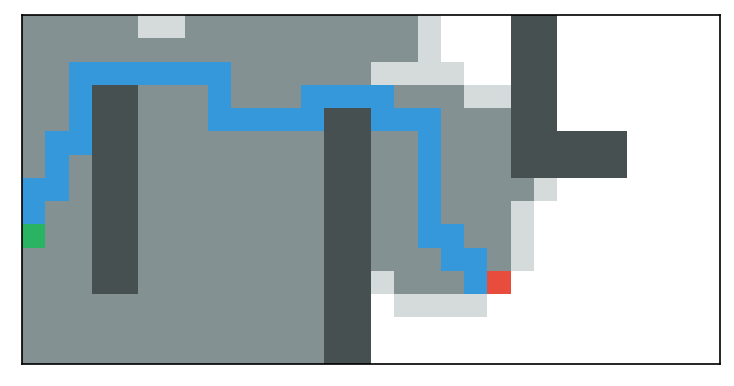

In [19]:
'''
Tests ## 0, 4, 8, 12, 14, 17, 18 should return incorrect result
'''

res = simple_test(astar, 0, inconsistent_heuristic, SearchTreePQS)

## A* Algorithm With Reexpansion

Let's add re-open/re-expansion capability to our implementation of `A*` and validate that everything works fine now.

In [20]:
class SearchTreePQSReexp: #SearchTree with reexpansion which uses PriorityQueue for OPEN and set for CLOSED
    
    def __init__(self):
        self._open = []           # heap for the OPEN nodes
        self._closed = {}       # set for the expanded nodes = CLOSED
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    '''
    open_is_empty should inform whether the OPEN is exhausted or not.
    In the former case the search main loop should be interrupted.
    '''
    
    def open_is_empty(self):
        return len(self._open) == 0
    
    '''
    Adding a (previously not expanded) node to the search-tree (i.e. to OPEN).
    It's either a totally new node (the one we never encountered before)
    or it can be a dublicate of the node that currently resides in OPEN.
    It's up to us how to handle dublicates in OPEN. We can either 
    detect dublicates upon adding (i.e. inside this method) or detect them
    lazily, when we are extracting a node for further expansion.
    Not detecting dublicates at all may work in certain setups but let's not
    consider this option.
    '''    
    def add_to_open(self, item):
        heappush(self._open, item)   
    
    '''
    Extracting the best node (i.e. the one with the minimal key 
    = min f-value = min g-value (for Dijkstra)) from OPEN.
    This node will be expanded further on in the main loop of the search.
    ''' 
    
    def was_expanded(self, item):
        return item in self._closed
        
    def re_expand(self, item):
        old_data = self._closed[item]
        if old_data[0] != item.g:
            if old_data[0] < item.g:
                item.g, item.parent = old_data
                item.f = item.g + item.h
            self.add_to_open(item)
            del self._closed[item]
        
        
    def get_best_node_from_open(self):
        best_node = heappop(self._open)
        
        while self.was_expanded(best_node) and not self.open_is_empty():
            best_node = heappop(self._open)
        
        return best_node

    def add_to_closed(self, item):
        self._closed[item] = (item.g, item.parent)

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates


In [21]:
def astar_reexpansion(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None):
    '''
    astra which works with consisten heuristics
    '''
    ast = search_tree()
    steps = 0
    nodes_created = 0
    
    goal = (goal_i, goal_j)
    start = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, *goal), parent=None)
    ast.add_to_open(start)
    
    answer = None
    current_f = float('+inf')
    
    best_node = None
    
    while not ast.open_is_empty() and (best_node is None or best_node.f < current_f):
        steps += 1
        best_node = ast.get_best_node_from_open()
        best = (best_node.i, best_node.j)
        ast.add_to_closed(best_node)
        
        
        if (best == goal):
            if current_f > best_node.f:
                answer = best_node
                current_f = best_node.f
                continue
        
        for succ in grid_map.get_neighbors(*best):
            new_g = best_node.g + compute_cost(*best, *succ)
            
            if  ((new_g + heuristic_func(*succ, *goal) <= current_f) and 
                    (best_node.parent is None) or (succ != (best_node.parent.i, best_node.parent.j))):
                new_node = Node(*succ, new_g, heuristic_func(*succ, *goal), parent=best_node)
                
                nodes_created += 1
                
                if ast.was_expanded(new_node):
                    ast.re_expand(new_node)
                else:   
                    ast.add_to_open(new_node)
        
    if answer is not None:
         return True, answer, steps, nodes_created, None, ast.CLOSED
    
    return False, None, steps, nodes_created, ast.OPEN, ast.CLOSED

### Tests with inconsistent heuristic function

Path found! Length: 38. Nodes created: 863. Number of steps: 239. Correct: False


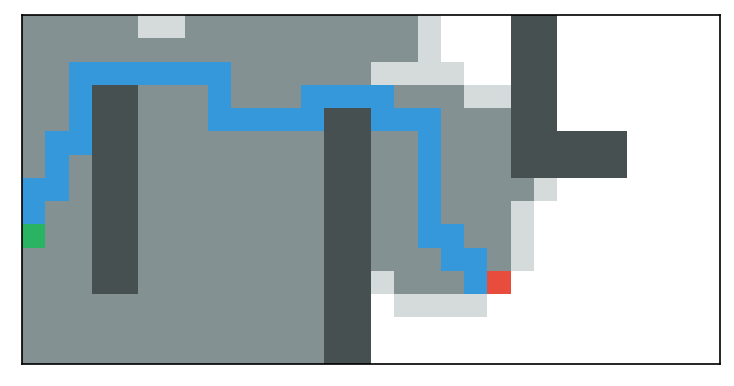

Path found! Length: 36. Nodes created: 1226. Number of steps: 452. Correct: True


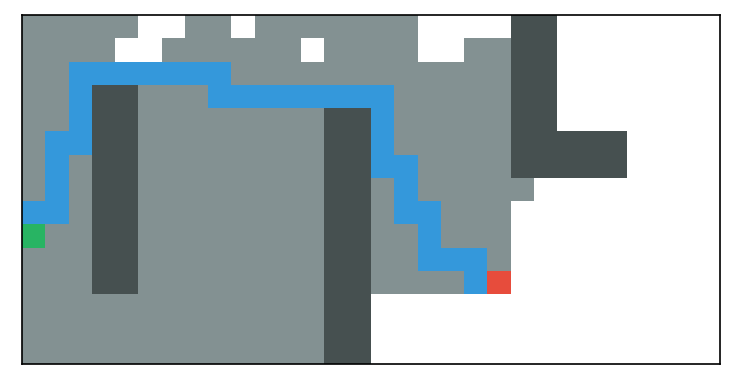

CPU times: total: 78.1 ms
Wall time: 77 ms


In [22]:
'''
Let's now try some tests that previously resulted in wrong paths.

Tests ## 0, 4, 8, 12, 14, 17, 18.

Now everything should be OK and we can see re-expanded nodes in (sort of) red color.
'''

i = 0
res = simple_test(astar, i, inconsistent_heuristic, SearchTreePQS)
%time res = simple_test(astar_reexpansion, i, inconsistent_heuristic, SearchTreePQSReexp)

## A* and Tie-breakers

The influence of the tie-break criteria migh influence the performance of A* pretty much.

Let's implement two different 'second order' criterions (when f-value is the same -- look at the g-value) and see which one is better.

In [23]:
def lt_g_max(self, other):
    '''
    TODO
    '''
    if self.f != other.f:
        return self.f < other.f
    return self.g < other.g
    
def lt_g_min(self, other):
    '''
    TODO
    '''
    if self.f != other.f:
        return self.f < other.f
    return self.g > other.g

G_MAX (=H-MIN) tie-breaker
Path found! Length: 30. Nodes created: 558. Number of steps: 152. Correct: True


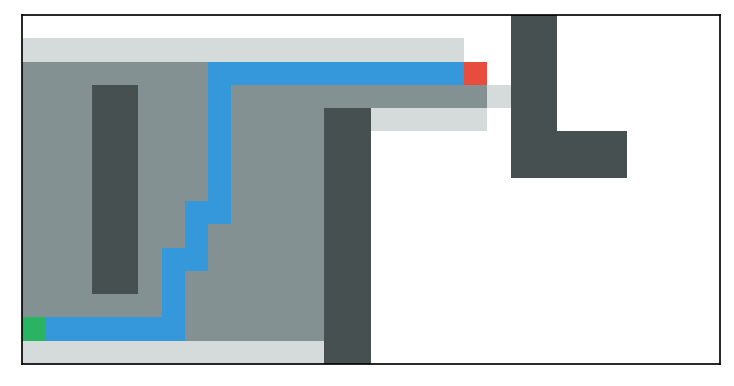

G_MIN (=H-MAX) tie-breaker
Path found! Length: 30. Nodes created: 107. Number of steps: 31. Correct: True


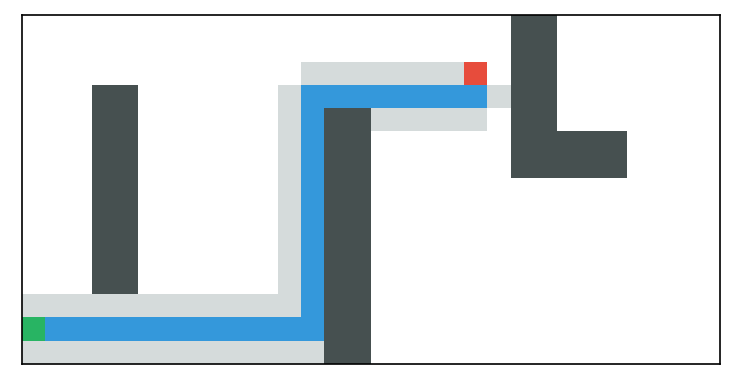

In [24]:
i = 1

print("G_MAX (=H-MIN) tie-breaker")
Node.__lt__ = lt_g_max
res1 = simple_test(astar, i, manhattan_distance, SearchTreePQS)

print("G_MIN (=H-MAX) tie-breaker")
Node.__lt__ = lt_g_min
res2 = simple_test(astar, i, manhattan_distance, SearchTreePQS)

### Run massive tests

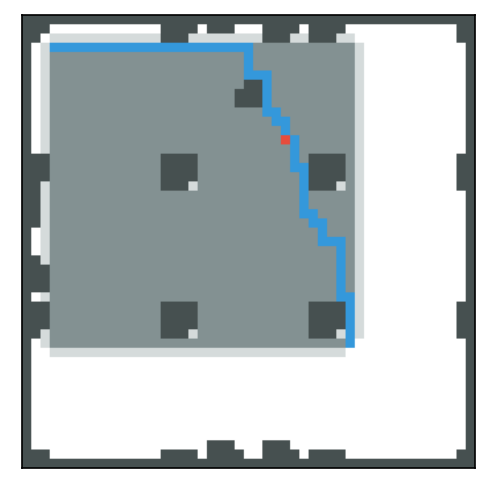

Path found! Length: 64. Nodes created: 3978. Number of steps: 1017. Correct: True


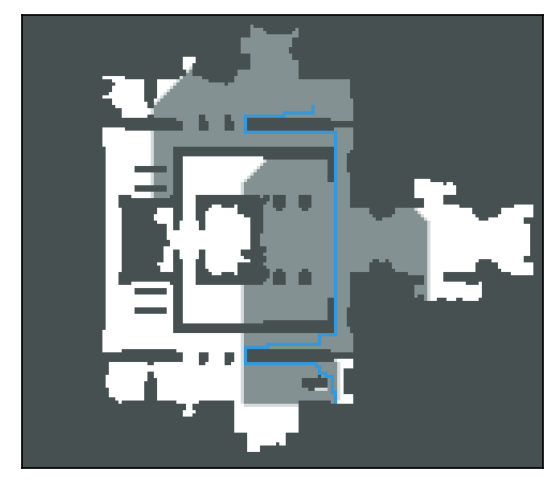

Path found! Length: 197. Nodes created: 14114. Number of steps: 3734. Correct: True


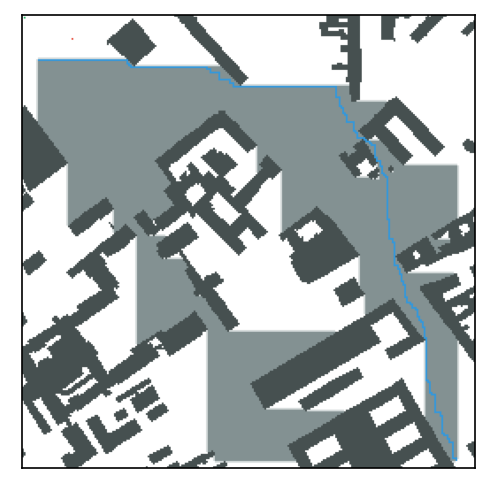

Path found! Length: 462. Nodes created: 83802. Number of steps: 21282. Correct: True


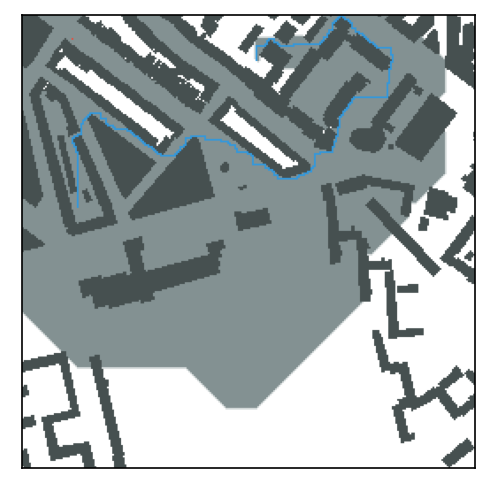

Path found! Length: 498. Nodes created: 105357. Number of steps: 27371. Correct: True


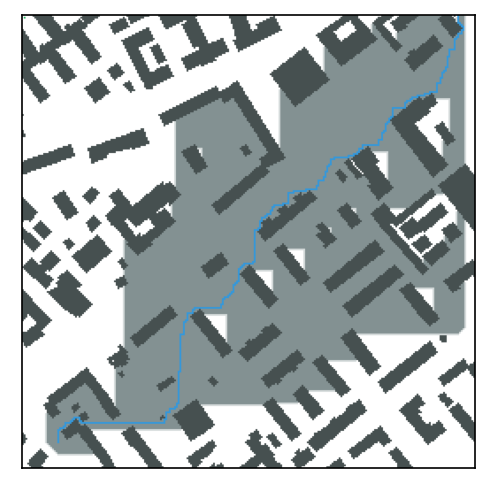

Path found! Length: 479. Nodes created: 94120. Number of steps: 24290. Correct: True


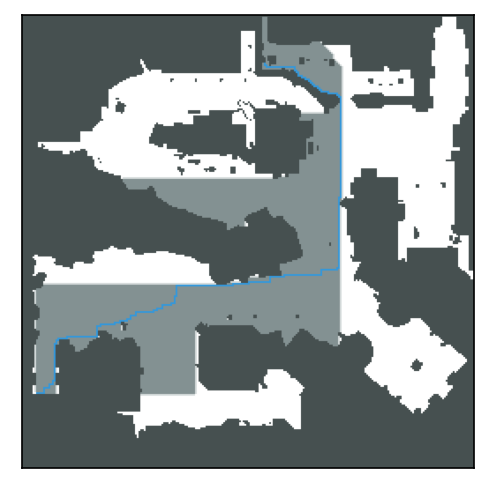

Path found! Length: 402. Nodes created: 44193. Number of steps: 11282. Correct: True


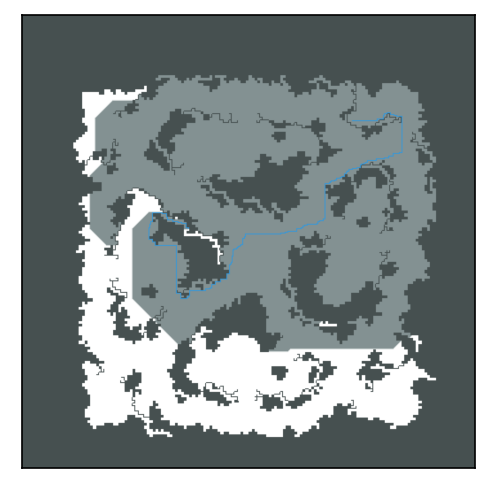

Path found! Length: 721. Nodes created: 292216. Number of steps: 75119. Correct: True


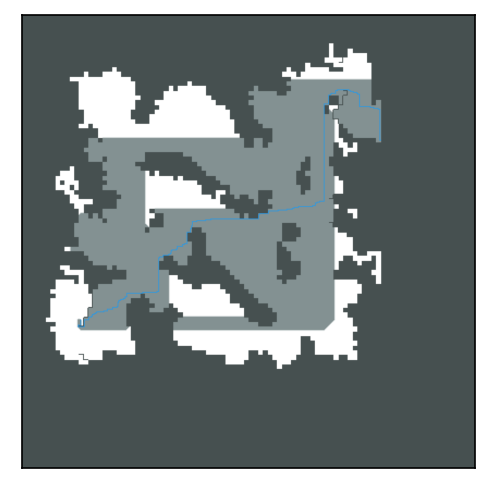

Path found! Length: 678. Nodes created: 196664. Number of steps: 49829. Correct: True


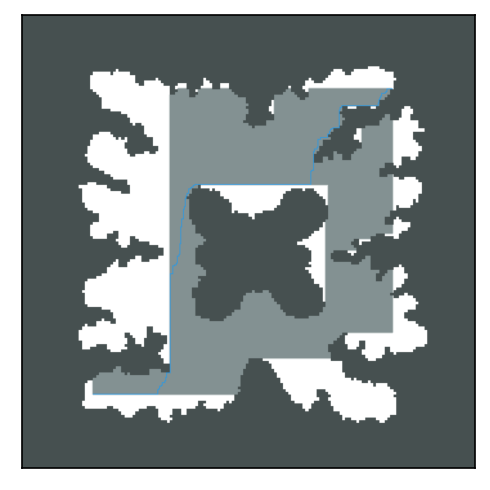

Path found! Length: 683. Nodes created: 209613. Number of steps: 52824. Correct: True
CPU times: total: 9.67 s
Wall time: 9.7 s


In [25]:
Node.__lt__ = lt_g_max
%time g_max_results = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQS)

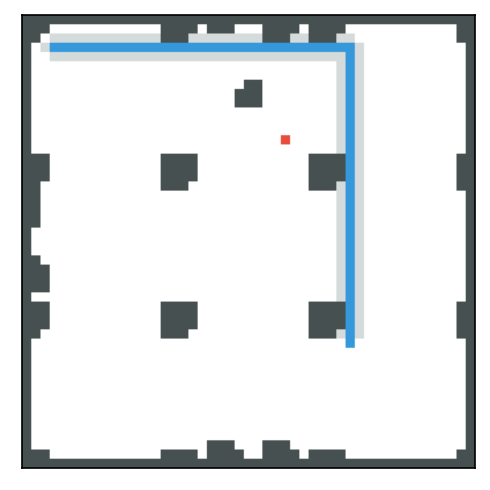

Path found! Length: 64. Nodes created: 241. Number of steps: 65. Correct: True


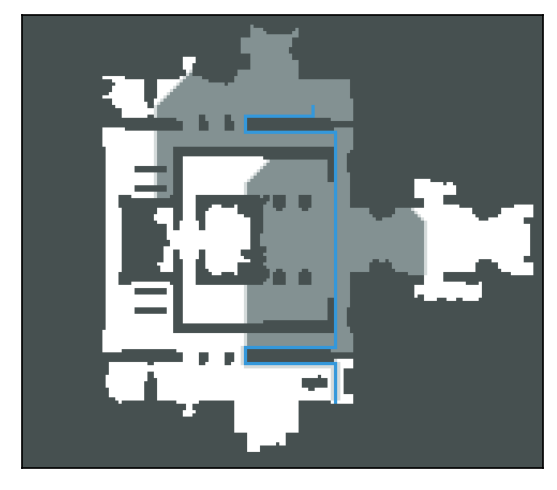

Path found! Length: 197. Nodes created: 12611. Number of steps: 3341. Correct: True


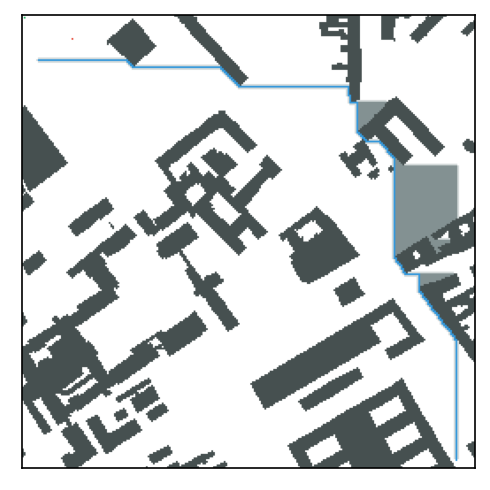

Path found! Length: 462. Nodes created: 8339. Number of steps: 2164. Correct: True


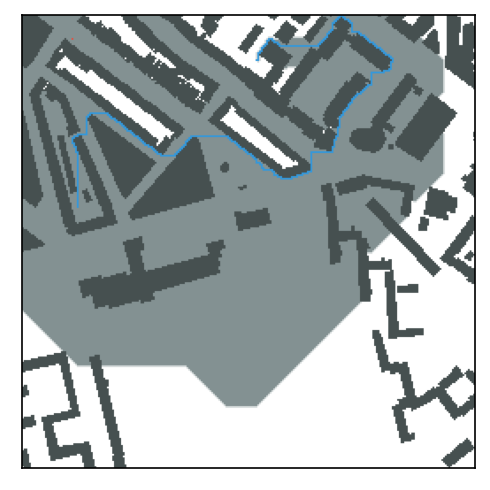

Path found! Length: 498. Nodes created: 104102. Number of steps: 27047. Correct: True


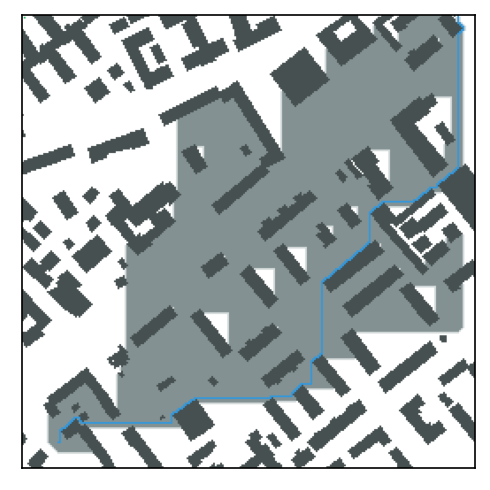

Path found! Length: 479. Nodes created: 90953. Number of steps: 23455. Correct: True


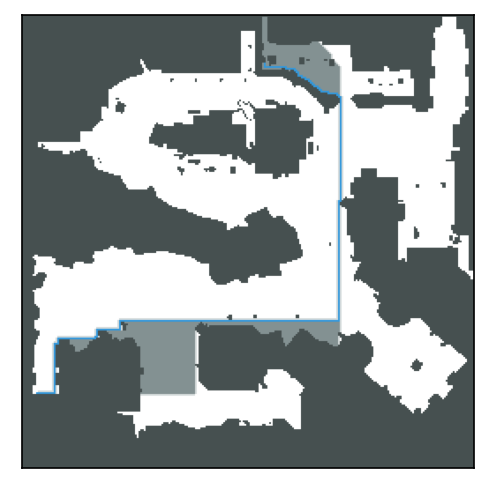

Path found! Length: 402. Nodes created: 11733. Number of steps: 3062. Correct: True


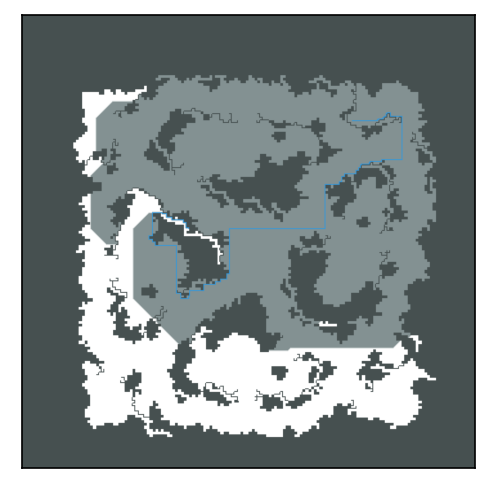

Path found! Length: 721. Nodes created: 289910. Number of steps: 74525. Correct: True


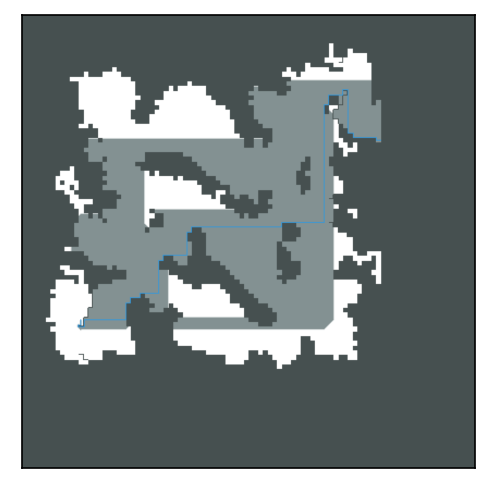

Path found! Length: 678. Nodes created: 192896. Number of steps: 48862. Correct: True


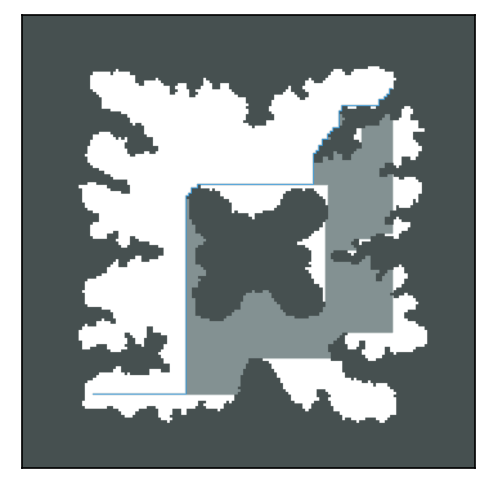

Path found! Length: 683. Nodes created: 111085. Number of steps: 28092. Correct: True
CPU times: total: 9.05 s
Wall time: 9.1 s


In [26]:
Node.__lt__ = lt_g_min
%time g_min_results = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQS)

In [27]:
TASKS_NUM = 9

g_min_steps = 0
g_max_steps = 0
g_min_nodes = 0
g_max_nodes = 0  

for i in range(TASKS_NUM):
    g_min_steps += g_min_results['st'][i]
    g_max_steps += g_max_results['st'][i]
    
    g_min_nodes += g_min_results['nc'][i]
    g_max_nodes += g_max_results['nc'][i]
    
g_min_steps /= TASKS_NUM
g_max_steps /= TASKS_NUM
g_min_nodes /= TASKS_NUM
g_max_nodes /= TASKS_NUM    

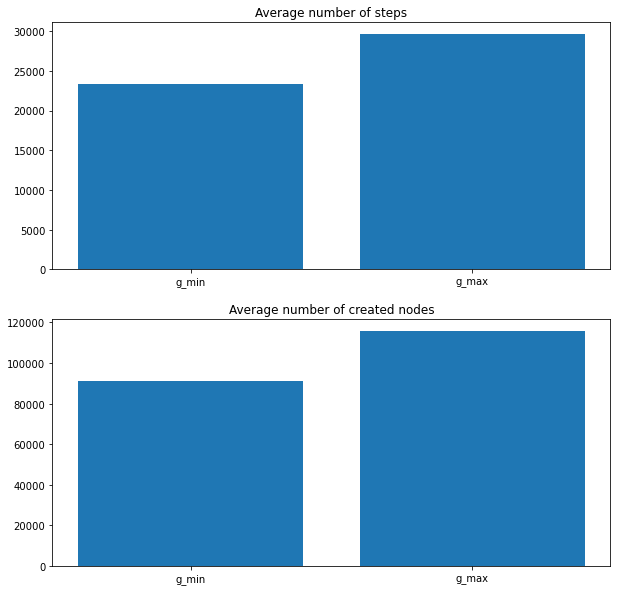

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].set_title("Average number of steps")
ax[1].set_title("Average number of created nodes")
ax[0].bar(["g_min","g_max"], [g_min_steps, g_max_steps])
ax[1].bar(["g_min","g_max"], [g_min_nodes, g_max_nodes]);